# Handleiding: Opstellen van een Neuraal Netwerk met TensorFlow in Python

## Inhoudsopgave

1. [Introductie](#introductie)
2. [Benodigdheden](#benodigdheden)
3. [Data Voorbereiden](#data-voorbereiden)
4. [Model Bouwen](#model-bouwen)
5. [Model Compileren](#model-compileren)
6. [Model Trainen](#model-trainen)
7. [Model Evalueren](#model-evalueren)
8. [Voorspellingen Doen](#voorspellingen-doen)
9. [Model Opslaan en Laden](#model-opslaan-en-laden)
10. [Visualisaties (optioneel)](#visualisaties-optioneel)
11. [Vervolgstappen en Tips](#vervolgstappen-en-tips)

# Packages 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, callbacks, preprocessing
from sklearn.model_selection import train_test_split 
from keras.layers import Input, Dense, Conv1D, Flatten
from keras.models import Model, Sequential
from sklearn.preprocessing import MinMaxScaler
import keras




print("VERSIES:")
print(f"{'- Pandas':<12} = {pd.__version__}")
print(f"{'- Numpy':<12} = {np.__version__}")
print(f"{'- Matplotlib':<12} = {plt.matplotlib.__version__}")
print(f"{'- Tensorflow':<12} = {tf.__version__}")
print(f"{'- Keras':<12} = {keras.__version__}")

VERSIES:
- Pandas     = 2.2.3
- Numpy      = 1.26.4
- Matplotlib = 3.10.1
- Tensorflow = 2.15.0
- Keras      = 2.15.0


# CV Inlezen

   Tijd (s)  Setpoint (m)  Hoogte (m)      Fout  Fout_Integratie  \
0      0.00      0.587040    0.004019  0.587040         0.005870   
1      0.00      0.936474    0.012057  0.932455         0.015195   
2      0.01      0.936474    0.024114  0.924417         0.024439   
3      0.02      0.936474    0.040190  0.912360         0.033563   
4      0.03      0.936474    0.060285  0.896284         0.042526   

   Fout_Afgeleide  PWM  
0       58.704010  1.0  
1       34.541507  1.0  
2       -0.803800  1.0  
3       -1.205700  1.0  
4       -1.607600  1.0  
Index(['Tijd (s)', 'Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie',
       'Fout_Afgeleide', 'PWM'],
      dtype='object')
          Tijd (s)  Setpoint (m)   Hoogte (m)         Fout  Fout_Integratie  \
count  4788.000000   4788.000000  4788.000000  4788.000000      4788.000000   
mean     23.925002      0.728594     0.725644     0.003084         0.142336   
std      13.823205      0.163707     0.168347     0.053353         0.0145

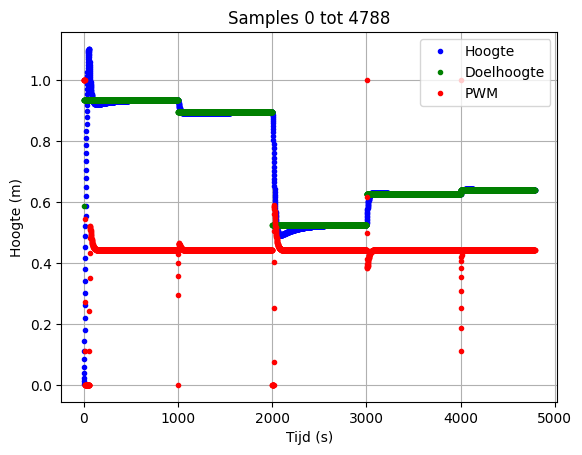

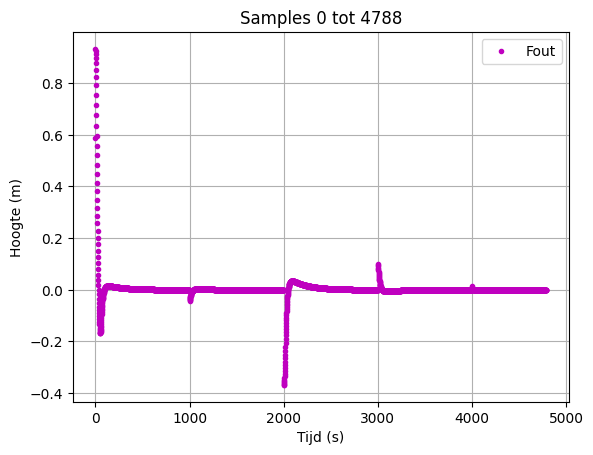

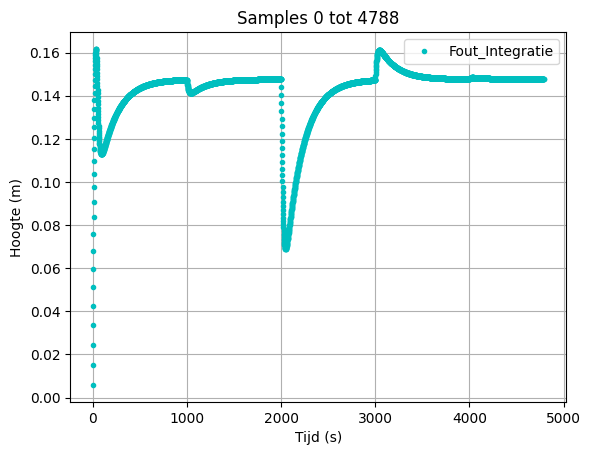

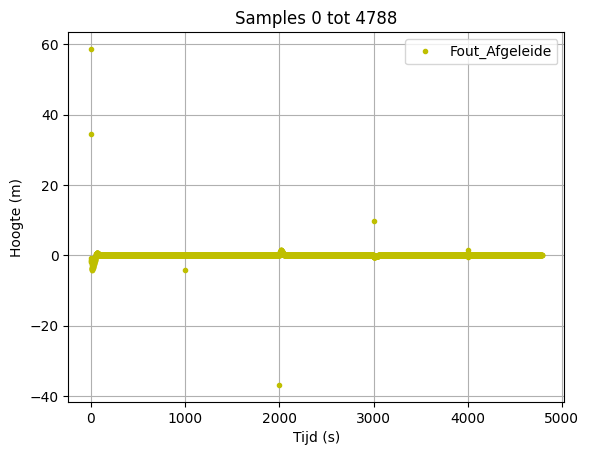

In [2]:


CSV_PATH = '/Users/mitchelreints/Desktop/05_Development/#Projecten/PEE51 - AIRegelsysteem/simulatie_resultaten.csv'
CSV_DATA = pd.read_csv(CSV_PATH)
print(CSV_DATA.head())
print(CSV_DATA.columns)
print(CSV_DATA.describe())
print(CSV_DATA.info())
print(CSV_DATA.shape)
print(CSV_DATA.dtypes)
print(CSV_DATA.isnull().sum())
print(CSV_DATA.nunique())
print(CSV_DATA.memory_usage(deep=True))
print(CSV_DATA)

# Toon aantal samples
total_samples = len(CSV_DATA)
print(f"Aantal samples: {total_samples}")
print(f"Indexbereik: 0 t/m {total_samples - 1}")

# Dynamisch start en end kiezen
start = 0
end = min(20000, total_samples)

# Veiligheidscheck
if end > start:
    x_range = range(start, end)

    plt.figure()
    plt.plot(x_range, CSV_DATA["Hoogte (m)"][start:end], 'b.', label="Hoogte")
    plt.plot(x_range, CSV_DATA["Setpoint (m)"][start:end], 'g.', label="Doelhoogte")
    plt.plot(x_range, CSV_DATA["PWM"][start:end], 'r.', label="PWM")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout"][start:end], 'm.', label="Fout")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Integratie"][start:end], 'c.', label="Fout_Integratie")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.figure()
    plt.plot(x_range, CSV_DATA["Fout_Afgeleide"][start:end], 'y.', label="Fout_Afgeleide")
    plt.title(f"Samples {start} tot {end}")
    plt.xlabel("Tijd (s)")
    plt.ylabel("Hoogte (m)")
    plt.grid(True)
    plt.legend()

    plt.show()
else:
    print("⚠️ Niet genoeg samples om in dit bereik te plotten.")

In [3]:

# Selecteer features en target
features = CSV_DATA[['Setpoint (m)', 'Hoogte (m)', 'Fout', 'Fout_Integratie', 'Fout_Afgeleide']].to_numpy()
target = CSV_DATA['PWM'].to_numpy()

# # Normaliseer alleen de features
# feature_scaler = MinMaxScaler()
# features = feature_scaler.fit_transform(features_raw)

# Print informatie
print(f"Features shape: {features.shape}")
print(f"Target shape: {target.shape}\n")

print("🔹 Originele features (eerste 5 samples):")
print(features[:5])

print("\n🔸 Genormaliseerde features (eerste 5 samples):")
print(features[:5])

print("\n🎯 Target (eerste 5 waarden):")
print(target[:5])

# Voor inverse transform later:
# originele_features = feature_scaler.inverse_transform(features)



Features shape: (4788, 5)
Target shape: (4788,)

🔹 Originele features (eerste 5 samples):
[[ 5.8704000e-01  4.0190000e-03  5.8704000e-01  5.8700000e-03
   5.8704010e+01]
 [ 9.3647400e-01  1.2057000e-02  9.3245500e-01  1.5195000e-02
   3.4541507e+01]
 [ 9.3647400e-01  2.4114000e-02  9.2441700e-01  2.4439000e-02
  -8.0380000e-01]
 [ 9.3647400e-01  4.0190000e-02  9.1236000e-01  3.3563000e-02
  -1.2057000e+00]
 [ 9.3647400e-01  6.0285000e-02  8.9628400e-01  4.2526000e-02
  -1.6076000e+00]]

🔸 Genormaliseerde features (eerste 5 samples):
[[ 5.8704000e-01  4.0190000e-03  5.8704000e-01  5.8700000e-03
   5.8704010e+01]
 [ 9.3647400e-01  1.2057000e-02  9.3245500e-01  1.5195000e-02
   3.4541507e+01]
 [ 9.3647400e-01  2.4114000e-02  9.2441700e-01  2.4439000e-02
  -8.0380000e-01]
 [ 9.3647400e-01  4.0190000e-02  9.1236000e-01  3.3563000e-02
  -1.2057000e+00]
 [ 9.3647400e-01  6.0285000e-02  8.9628400e-01  4.2526000e-02
  -1.6076000e+00]]

🎯 Target (eerste 5 waarden):
[1. 1. 1. 1. 1.]


In [4]:
n_input = 2  # aantal tijdstappen per voorbeeld

X, y = [], []

for i in range(len(features) - n_input):
    X.append(features[i:i + n_input])
    y.append(target[i + n_input])  # de PWM bij het volgende moment

X = np.array(X)  # shape: (samples, n_input, features)
y = np.array(y)

print("X shape:", X.shape)  # (samples, tijdstappen, features)
print("y shape:", y.shape)  # (samples,)
print("X:", X)  # (samples, tijdstappen, features)
print("y:", y) 

X shape: (4786, 2, 5)
y shape: (4786,)
X: [[[ 5.8704000e-01  4.0190000e-03  5.8704000e-01  5.8700000e-03
    5.8704010e+01]
  [ 9.3647400e-01  1.2057000e-02  9.3245500e-01  1.5195000e-02
    3.4541507e+01]]

 [[ 9.3647400e-01  1.2057000e-02  9.3245500e-01  1.5195000e-02
    3.4541507e+01]
  [ 9.3647400e-01  2.4114000e-02  9.2441700e-01  2.4439000e-02
   -8.0380000e-01]]

 [[ 9.3647400e-01  2.4114000e-02  9.2441700e-01  2.4439000e-02
   -8.0380000e-01]
  [ 9.3647400e-01  4.0190000e-02  9.1236000e-01  3.3563000e-02
   -1.2057000e+00]]

 ...

 [[ 6.4136500e-01  6.4137300e-01 -8.0000000e-06  1.4766200e-01
    4.0000000e-06]
  [ 6.4136500e-01  6.4137300e-01 -8.0000000e-06  1.4766200e-01
    4.0000000e-06]]

 [[ 6.4136500e-01  6.4137300e-01 -8.0000000e-06  1.4766200e-01
    4.0000000e-06]
  [ 6.4136500e-01  6.4137300e-01 -8.0000000e-06  1.4766200e-01
    4.0000000e-06]]

 [[ 6.4136500e-01  6.4137300e-01 -8.0000000e-06  1.4766200e-01
    4.0000000e-06]
  [ 6.4136500e-01  6.4137300e-01 -8.0000

Test range: index 3000–3956
Train samples: 3829
Test samples: 957


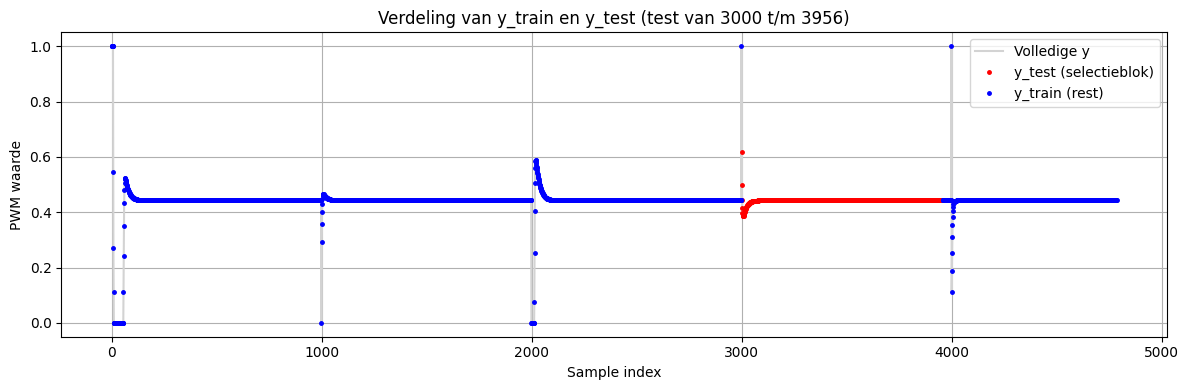

In [5]:
# Lengte van dataset
n = len(y)

# Hoeveel samples is 20%
test_len = int(n * 0.2)

# Kies handmatig waar je testdata begint
test_start = 3000  # bijvoorbeeld index 3000
test_end = test_start + test_len

# Zorg dat je niet buiten de dataset gaat
assert test_end <= n, "Testblok gaat buiten dataset!"

# Slice y en X
X_test, y_test = X[test_start:test_end], y[test_start:test_end]
X_train = np.concatenate((X[:test_start], X[test_end:]), axis=0)
y_train = np.concatenate((y[:test_start], y[test_end:]), axis=0)

print(f"Test range: index {test_start}–{test_end-1}")
print(f"Train samples: {len(y_train)}")
print(f"Test samples: {len(y_test)}")


import matplotlib.pyplot as plt

full_indices = np.arange(len(y))
idx_test = np.arange(test_start, test_end)
idx_train = np.setdiff1d(full_indices, idx_test)

plt.figure(figsize=(12, 4))
plt.plot(full_indices, y, color='lightgray', label="Volledige y")
plt.plot(idx_test, y_test, 'r.', label="y_test (selectieblok)", markersize=5)
plt.plot(idx_train, y_train, 'b.', label="y_train (rest)", markersize=5)

plt.title(f"Verdeling van y_train en y_test (test van {test_start} t/m {test_end - 1})")
plt.xlabel("Sample index")
plt.ylabel("PWM waarde")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Model aanmaken

In [6]:

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(n_input, X.shape[2])),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1)  # Één PWM-waarde voorspellen
])
print("n_input:", n_input)
print("X.shape[2]:", X.shape[2])
model.summary()

n_input: 2
X.shape[2]: 5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             352       
                                                                 
 flatten (Flatten)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 64)                2112      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 2529 (9.88 KB)
Trainable params: 2529 (9.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Model Compilen

In [7]:
model.compile(optimizer='adam', loss='mse')

# Model Trainen

In [8]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
120/120 [==============================] - 0s 872us/step - loss: 0.0352 - val_loss: 0.0027
Epoch 2/100
120/120 [==============================] - 0s 446us/step - loss: 0.0050 - val_loss: 0.0031
Epoch 3/100
120/120 [==============================] - 0s 450us/step - loss: 0.0034 - val_loss: 7.8450e-04
Epoch 4/100
120/120 [==============================] - 0s 452us/step - loss: 0.0041 - val_loss: 0.0034
Epoch 5/100
120/120 [==============================] - 0s 453us/step - loss: 0.0080 - val_loss: 3.5605e-04
Epoch 6/100
120/120 [==============================] - 0s 451us/step - loss: 0.0071 - val_loss: 0.0028
Epoch 7/100
120/120 [==============================] - 0s 445us/step - loss: 0.0079 - val_loss: 9.6185e-04
Epoch 8/100
120/120 [==============================] - 0s 440us/step - loss: 0.0097 - val_loss: 0.0026
Epoch 9/100
120/120 [==============================] - 0s 436us/step - loss: 0.0054 - val_loss: 7.4241e-04
Epoch 10/100
120/120 [==============================] - 0

# Training en validation loss Plotten

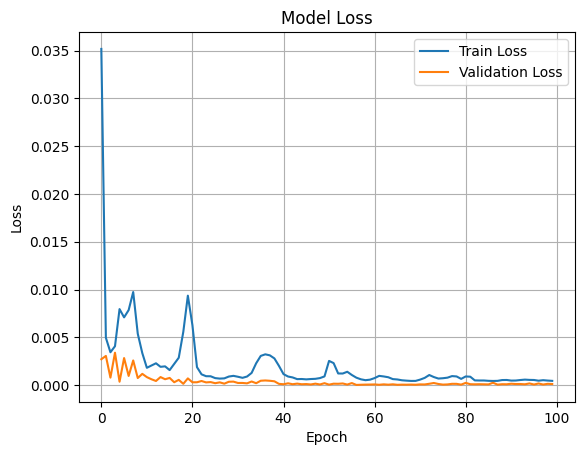

In [9]:
# Plot the training history
loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(1, len(loss) + 1)


# Plot loss
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

# PREDICT


30/30 [==============================] - 0s 298us/step - loss: 1.1693e-04

loss : 0.00011693008855218068
y_test heeft 957 samples (indexbereik: 0 t/m 956)


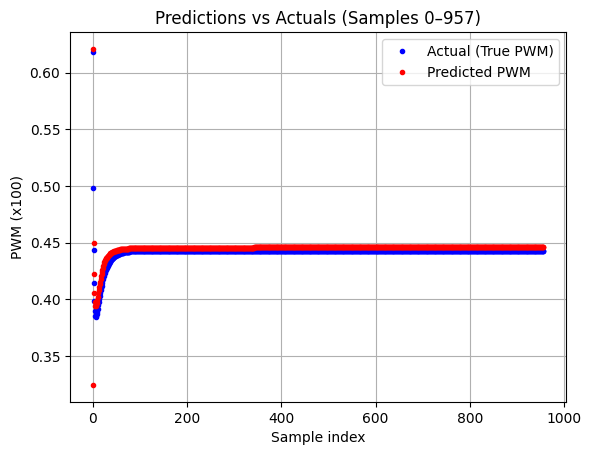

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Maak voorspellingen
predictions = model.predict(X_test).flatten()

score = model.evaluate(X_test, y_test)
print(f"\n{model.metrics_names[0]} : {score}")

print(f"y_test heeft {len(y_test)} samples (indexbereik: 0 t/m {len(y_test) - 1})")

# Stel de range in
start = 0
end = min(3000, len(y_test)) 

# Plot alleen het gewenste bereik
plt.figure()
plt.title(f"Predictions vs Actuals (Samples {start}–{end})")
plt.plot(range(start, end), y_test[start:end], 'b.', label='Actual (True PWM)')
plt.plot(range(start, end), predictions[start:end], 'r.', label='Predicted PWM')
plt.xlabel("Sample index")
plt.ylabel("PWM (x100)")
plt.legend()
plt.grid(True)

plt.show()

In [11]:
model.save("pwm_model")


converter = tf.lite.TFLiteConverter.from_saved_model("pwm_model")
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS]

tflite_model = converter.convert()
with open("pwm_model.tflite", "wb") as f:
    f.write(tflite_model)
print("✅ Model succesvol getraind en geconverteerd(.tflite)")

INFO:tensorflow:Assets written to: pwm_model/assets


INFO:tensorflow:Assets written to: pwm_model/assets


✅ Model succesvol getraind en geconverteerd(.tflite)


2025-06-11 13:25:56.100688: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2025-06-11 13:25:56.100698: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2025-06-11 13:25:56.100888: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: pwm_model
2025-06-11 13:25:56.101290: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2025-06-11 13:25:56.101294: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: pwm_model
2025-06-11 13:25:56.102009: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled
2025-06-11 13:25:56.102523: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2025-06-11 13:25:56.122660: I tensorflow/cc/saved_model/loader.cc:217] Running initialization op on SavedModel bundle at path: pwm_model
2025-06-11 13:25:56.129635: 

# xxd -i pwm_model.tflite > pwm_model.cc